# Salt stress downregulates AhrC

In [1]:
from __future__ import print_function, division, absolute_import

import sys

import qminospy
from qminospy.me2 import ME_NLP

# python imports
from copy import copy
import re
from os.path import join
from collections import defaultdict
import pickle

# third party imports
import pandas
import cobra
from tqdm import tqdm
import numpy as np
import scipy
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'

# COBRAme
import cobrame
from cobrame.util import building, mu, me_model_interface
from cobrame.io.json import save_json_me_model, save_reduced_json_me_model

# ECOLIme
import bacillusme
from bacillusme import (transcription, translation, flat_files, generics, formulas, compartments)
from bacillusme.util.helper_functions import *
%load_ext autoreload
%autoreload 2
print(cobra.__file__)
print(cobrame.__file__)
print(bacillusme.__file__)

/home/jt/me_modeling/lib/python3.6/site-packages/cobra-0.5.11-py3.6-linux-x86_64.egg/cobra/io/sbml3.py:24: UserWarning: Install lxml for faster SBML I/O
  warn("Install lxml for faster SBML I/O")
/home/jt/me_modeling/lib/python3.6/site-packages/cobra-0.5.11-py3.6-linux-x86_64.egg/cobra/io/__init__.py:12: UserWarning: cobra.io.sbml requires libsbml
  warn("cobra.io.sbml requires libsbml")


/home/jt/me_modeling/lib/python3.6/site-packages/cobra-0.5.11-py3.6-linux-x86_64.egg/cobra/__init__.py
/home/jt/UCSD/cobrame/cobrame/__init__.py
/home/jt/UCSD/bacillusme-master/bacillusme/__init__.py


Load

In [787]:
eco_directory = join(flat_files.ecoli_files_dir, 'iJO1366.json')
ijo_directory = join(flat_files.ecoli_files_dir, 'iYO844.json')
uni_directory = join(flat_files.ecoli_files_dir, 'universal_model.json')

eco = cobra.io.load_json_model(eco_directory)
bsub = cobra.io.load_json_model(ijo_directory)
uni = cobra.io.load_json_model(uni_directory)

bsub.optimize()
base_mu = bsub.solution.f

In [949]:
gene_dictionary = pd.read_csv('gene_name_dictionary.csv',index_col=1)
ions = ['na1_e','ca2_e','zn2_e','k_e']

## RNASeq data

In [789]:
data = pd.read_csv('rna_seq/RNAseq_raw.csv',index_col=1)

In [1035]:
df = control_data.join(stress_data)


In [1045]:
a = [[i for i in df.columns.values],[i.split('_')[0] for i in df.columns.values]]

In [1046]:
pd.DataFrame(a).T

,0,1,2,3,4,5
0,SMM_1_hyb25347102,SMM_2_hyb25346902,SMM_3_hyb25346702,Salt_1_hyb25345102,Salt_2_hyb25344802,Salt_3_hyb25347202
1,SMM,SMM,SMM,Salt,Salt,Salt


RNAseq data appears to be normalized. That means that roughly they have the same numbre of cells.

In [790]:
samples = data.columns
control_data = data[samples[samples.str.contains('SMM_')]]
stress_data = data[samples[samples.str.contains('Salt')]]
fold_change = np.divide(stress_data,control_data)

### Arginine biosynthesis

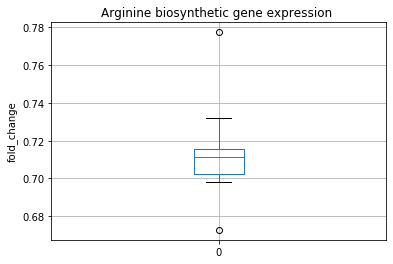

In [839]:
genes = ['argG', 'argH', 'argC', 'argJ', 'argB', 'argD', 'argF', 'carA', 'carB']
fold_change.loc[gene_dictionary.loc[genes]['locus_id']].mean(axis=1).to_frame().boxplot()
plt.ylabel('fold_change')
plt.title('Arginine biosynthetic gene expression ')

Arginine biosynthesis is downregulated in salt stress.

### Transporter expression

In [817]:
# Identify uptake and secretion transporters
uptake_rxns = get_transport_reactions(bsub,'na1_e',model_type='m')
transporter_ids=[]
for rxn in uptake_rxns:
    genes_uptake = rxn.genes
    transporters = [gene.id for gene in genes_uptake]
    for t in transporters:
        transporter_ids.append(t)
        
secretion_rxns = get_transport_reactions(bsub,'na1_e',comps=['c','e'],model_type='m')
secretor_ids=[]
for rxn in secretion_rxns:
    genes_secretion = rxn.genes
    transporters = [gene.id for gene in genes_secretion]
    for t in transporters:
        secretor_ids.append(t)

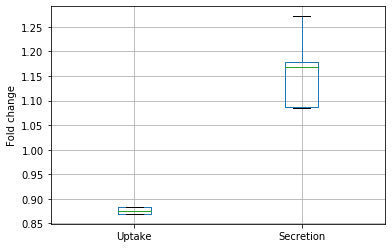

<Figure size 504x288 with 0 Axes>

In [843]:
fig,ax = plt.subplots(1)
plt.figure(figsize=(7,4))
fold_change.loc[transporter_ids].mean(axis=1).to_frame().boxplot(ax=ax,widths=0.20, positions=[0.],sym='')
fold_change.loc[secretor_ids].mean(axis=1).to_frame().boxplot(ax=ax,widths=0.20, positions=[1.0],sym='')

ax.set_ylabel('Fold change')
ax.set_xticklabels(['Uptake','Secretion'])
fig.savefig('figures/arginine_transporter_regulation.svg',format='SVG')


In [1234]:
for g,row in fold_change.loc[transporter_ids].mean(axis=1).sort_values(ascending=False).to_frame().iterrows():
    gene = list(gene_dictionary[gene_dictionary.locus_id==g].index)[0]
    print(g,gene,row[0])

BSU25420 yqeW 0.999493998743441
BSU10220 gltT 0.8838968958750705
BSU31580 maeN 0.8750955795375385
BSU09130 tcyP 0.8693115917381992
BSU19350 yocS 0.8447218019926926


In [1237]:
for g,row in fold_change.loc[secretor_ids].mean(axis=1).sort_values(ascending=False).to_frame().iterrows():
    gene = list(gene_dictionary[gene_dictionary.locus_id==g].index)[0]
    print(g,gene,row[0])

BSU09850 khtU 1.4966330530278207
BSU33420 nhaK 1.2715532642326284
BSU31660 mrpG 1.2036050360747839
BSU31640 mrpE 1.179272931420055
BSU31650 mrpF 1.1791739108980464
BSU31620 mrpC 1.173003385827547
BSU31630 mrpD 1.1699366374204347
BSU31610 mrpB 1.1653232015702555
BSU31600 mrpA 1.1567100922569178
BSU11640 kefQ 1.096116024681016
BSU09680 nhaC 1.0850134766569601
BSU02760 natB 0.9155579217600844
BSU02750 natA 0.9094075635828137
BSU23560 mleN 0.857417528235067


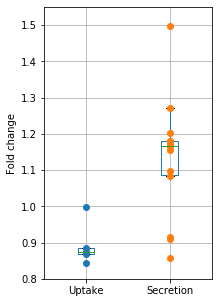

<Figure size 504x288 with 0 Axes>

In [1240]:
fig,ax = plt.subplots(1,figsize=(3,5))
plt.figure(figsize=(7,4))
fold_change.loc[transporter_ids].mean(axis=1).to_frame().boxplot(ax=ax,widths=0.20, positions=[0.],sym='')
fold_change.loc[secretor_ids].mean(axis=1).to_frame().boxplot(ax=ax,widths=0.20, positions=[1.0],sym='')


y = fold_change.loc[transporter_ids].mean(axis=1).to_frame().values
x = np.zeros(len(y))
ax.plot(x,y,'o')

y = fold_change.loc[secretor_ids].mean(axis=1).to_frame().values
x = np.ones(len(y))
ax.plot(x,y,'o')

ax.set_ylabel('Fold change')
ax.set_xticklabels(['Uptake','Secretion'])
ax.set_ylim([0.8,1.55])
fig.savefig('figures/arginine_transporter_regulation.svg',format='SVG')

Downregulation of uptake transporters means that either the same or a reduced amount of uptake transporters should be expressed in salt stress. That means that to properly model this in the ME-model it is necessary to add transport reactions that do not induce expression of transporters.

### Up and downregulation

In [1017]:
from scipy.stats import ttest_ind,t
alpha = 0.05
decision_df = pd.DataFrame(index=control_data.index,columns=['reg'])
for gene in tqdm(decision_df.index):
    
    a = control_data.loc[gene]
    b = stress_data.loc[gene]
    tval = ttest_ind(b,a).statistic

    pval = t.cdf(tval,df=(len(a)-1)+(len(b)-1))
    if pval > 0.95: # b>a?  
        decision_df.loc[gene]['reg'] = 1
    elif pval < 0.05: # b<a?
        decision_df.loc[gene]['reg'] = -1
    else:
        decision_df.loc[gene]['reg'] = 0


100%|██████████| 5875/5875 [00:18<00:00, 316.50it/s]


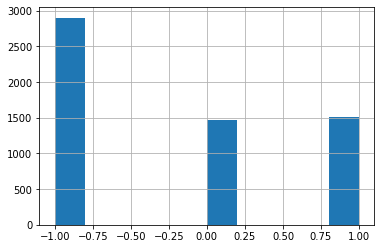

In [1018]:
decision_df['reg'].hist()

In [1019]:
decision_df

,reg
Locus_tag,
new_1_148,-1
new_24_297_c,0
new_150_409,-1
new_299_1067_c,0
BSU00010,-1
...,...
BSU41050,-1
new_4215104_4215254_c,-1
BSU41060,0


## M-model simulations

In [8]:
bsub = cobra.io.load_json_model(ijo_directory)
na1_e = bsub.metabolites.na1_e
## Separate sodium entrance and exit
bsub.reactions.EX_na1_e.lower_bound = 0
bsub.reactions.EX_na1_e.upper_bound = 0

# Create sodium metabolites
na1_in = cobra.Metabolite(id='na1_in')
na1_out = cobra.Metabolite(id='na1_out')
bsub.add_metabolites([na1_in,na1_out])

# Sodium uptake
rxn = cobra.Reaction(id='EX_na1_in')
rxn.add_metabolites({
    na1_in:-1.0
})
rxn.lower_bound = -1000
rxn.upper_bound = 0
bsub.add_reaction(rxn)
print(rxn.reaction)
# Sodium exit
rxn = cobra.Reaction(id='DM_na1_out')
rxn.add_metabolites({
    na1_out:-1.0
})
rxn.lower_bound = 0
rxn.upper_bound = 1000
bsub.add_reaction(rxn)
print(rxn.reaction)

na1_in <=> 
na1_out <=> 


In [9]:
uptake_rxns = get_reactions_of_met(bsub,'na1_e',s = -1,verbose=0)
exit_rxns = get_reactions_of_met(bsub,'na1_e',s = 1,verbose=0)

for rxn in uptake_rxns:
    coeff = rxn.pop(na1_e)
    rxn.add_metabolites({na1_in:coeff})
    print(rxn.reaction)
for rxn in exit_rxns:
    coeff = rxn.pop(na1_e)
    rxn.add_metabolites({na1_out:coeff})
    print(rxn.reaction)

mal__L_e + na1_in --> mal__L_c + na1_c
bilea_e + na1_in --> bilea_c + na1_c
3.0 na1_in + pi_e --> 3.0 na1_c + pi_c
glu__L_e + na1_in --> glu__L_c + na1_c
atp_c + h2o_c + na1_c --> adp_c + h_c + na1_out + pi_c
2.0 h_e + lac__L_c + mal__L_e + na1_c --> 2.0 h_c + lac__L_e + mal__L_c + na1_out
h_e + na1_c --> h_c + na1_out


In [10]:
# Sodium rates and simulation
na_rates = -np.arange(0,5,0.1)*1e-3
flux_dict = dict()
for rate in na_rates:
    bsub.reactions.get_by_id('EX_na1_in').lower_bound = rate
    bsub.reactions.get_by_id('EX_na1_in').upper_bound = rate
    solution = bsub.optimize()
    flux_dict[rate] = solution.x_dict
flux_responses = pd.DataFrame.from_dict(flux_dict)

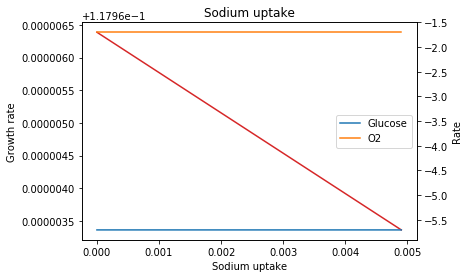

In [11]:
fig,ax1 = plt.subplots()
plt.title('Sodium uptake')

ax1.plot(-flux_responses.loc['EX_na1_in'],flux_responses.loc['BIOMASS_BS_10'],
            label = 'growth',color='tab:red')
ax1.set_xlabel('Sodium uptake')
ax1.set_ylabel('Growth rate')

ax2 = ax1.twinx()
ax2.plot(-flux_responses.loc['EX_na1_in'],flux_responses.loc['EX_o2_e'],
            label = 'Glucose')
ax2.plot(-flux_responses.loc['EX_na1_in'],flux_responses.loc['EX_glc__D_e'],
            label = 'O2')
ax2.set_ylabel('Rate')

ax2.legend()

M-model predicts an increase in growth rate at increased sodium uptake

In [12]:
gene_dictionary = pd.read_csv('gene_name_dictionary.csv',index_col=1)

In [13]:
flux_responses = pd.DataFrame.from_dict(flux_dict)

/home/jt/UCSD/ME_modelling/ME_env/lib/python3.6/site-packages/ipykernel_launcher.py:7 RuntimeWarning: invalid value encountered in true_divide


(0.9, 1.1)

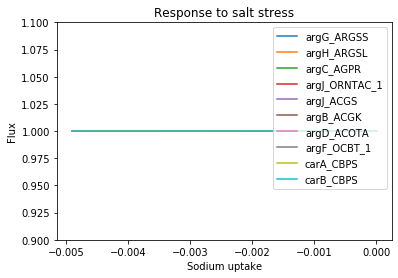

In [20]:
import pandas as pd
genes = ['argG', 'argH', 'argC', 'argJ', 'argB', 'argD', 'argF', 'carA', 'carB']
for idx,gene in enumerate(gene_dictionary.loc[genes]['locus_id'].values):
    rxns = bsub.genes.get_by_id(gene).reactions
    for rxn in rxns:
        flux_profile = abs(flux_responses.loc[rxn.id].values)
        flux_profile /= max(flux_profile)
        plt.plot(na_rates,flux_profile,label=genes[idx]+'_'+rxn.id)
plt.title('Response to salt stress')
plt.xlabel('Sodium uptake')
plt.ylabel('Flux')
plt.legend()
plt.ylim([0.9, 1.1])

Is it an artifact of growth rate increase?

In [16]:
bsub.reactions.get_by_id('EX_glc__D_e').lower_bound = -10
bsub.reactions.get_by_id('BIOMASS_BS_10').lower_bound = base_mu
bsub.reactions.get_by_id('BIOMASS_BS_10').upper_bound = base_mu

bsub.objective = 'EX_glc__D_e'
bsub.reactions.get_by_id('EX_glc__D_e').objective_coefficient = -1.

# Sodium rates and simulation
na_rates = -np.arange(0,5,0.1)*1e-3
flux_dict = dict()
for rate in na_rates:
    bsub.reactions.get_by_id('EX_na1_in').lower_bound = rate
    bsub.reactions.get_by_id('EX_na1_in').upper_bound = rate
    solution = bsub.optimize()
    flux_dict[rate] = solution.x_dict
flux_responses = pd.DataFrame.from_dict(flux_dict)

/home/jt/UCSD/ME_modelling/ME_env/lib/python3.6/site-packages/ipykernel_launcher.py:6 RuntimeWarning: invalid value encountered in true_divide


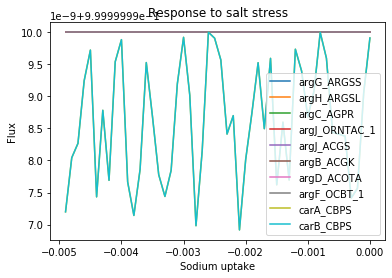

In [17]:
genes = ['argG', 'argH', 'argC', 'argJ', 'argB', 'argD', 'argF', 'carA', 'carB']
for idx,gene in enumerate(gene_dictionary.loc[genes]['locus_id'].values):
    rxns = bsub.genes.get_by_id(gene).reactions
    for rxn in rxns:
        flux_profile = abs(flux_responses.loc[rxn.id].values)
        flux_profile /= max(flux_profile)
        plt.plot(na_rates,flux_profile,label=genes[idx]+'_'+rxn.id)
plt.title('Response to salt stress')
plt.xlabel('Sodium uptake')
plt.ylabel('Flux')
plt.legend()

M-model is not able to capture the decrease in AhrC regulon

## ME-model simulations

In [6]:
with open('../me_models/solution.pickle', 'rb') as solution:
    me = pickle.load(solution)

Add those reactions that account for osmosis

In [940]:
# Add a copy of transport reactions that do not need a transporter
uptake_rxns = get_transport_reactions(me,'na1_e',comps=['e','c'])
osm_rxns = []
for rxn in uptake_rxns:
    stoich = rxn.stoichiometric_data.stoichiometry
    osm_id = rxn.id.split('_FWD')[0]+'_osm'
    
    if not hasattr(me.reactions,osm_id):
        osm_rxn = cobrame.MEReaction(osm_id)
        me.add_reaction(osm_rxn)

        osm_rxn.add_metabolites(stoich)
        osm_rxn.lower_bound=0
        osm_rxn.upper_bound=1000
        osm_rxns.append(osm_rxn)
        print(osm_rxn.id,osm_rxn.lower_bound,osm_rxn.upper_bound,osm_rxn.reaction)   


GLUt4_osm 0 1000 glu__L_e + na1_e <=> glu__L_c + na1_c
MALt4_osm 0 1000 mal__L_e + na1_e <=> mal__L_c + na1_c
PIt7_osm 0 1000 3.0 na1_e + pi_e <=> 3.0 na1_c + pi_c
BILEt4_osm 0 1000 bilea_e + na1_e <=> bilea_c + na1_c


Add sodium uptake and exit separately

In [941]:
from cobrame import MEReaction,Metabolite

na1_e = me.metabolites.na1_e
## Separate sodium entrance and exit
me.reactions.EX_na1_e.lower_bound = 0
me.reactions.EX_na1_e.upper_bound = 0

# Create sodium metabolites
na1_in = Metabolite(id='na1_in')
na1_out = Metabolite(id='na1_out')
me.add_metabolites([na1_in,na1_out])

# Sodium uptake
rxn = MEReaction(id='EX_na1_in')
rxn.add_metabolites({
    na1_in:-1.0
})
rxn.lower_bound = -1000
rxn.upper_bound = 0
me.add_reaction(rxn)
print(rxn.id,rxn.reaction)
# Sodium exit
rxn = MEReaction(id='DM_na1_out')
rxn.add_metabolites({
    na1_out:-1.0
})
rxn.lower_bound = 0
rxn.upper_bound = 1000
me.add_reaction(rxn)
print(rxn.id,rxn.reaction)

EX_na1_in na1_in <=> 
DM_na1_out na1_out <=> 


In [942]:
uptake_rxns = get_transport_reactions(me,'na1_e',comps=['e','c'])
exit_rxns = get_transport_reactions(me,'na1_e',comps=['c','e'])
for rxn in uptake_rxns:
    coeff = rxn.pop(na1_e)
    rxn.add_metabolites({na1_in:coeff})
    print(rxn.id,rxn.reaction)
print('\n')
for rxn in exit_rxns:
    coeff = rxn.pop(na1_e)
    rxn.add_metabolites({na1_out:coeff})
    print(rxn.id,rxn.reaction)

GLUt4_FWD_BSU10220-MONOMER 8.12128100619354e-5*mu BSU10220-MONOMER + glu__L_e + na1_in <=> glu__L_c + na1_c
MALt4_FWD_BSU31580-MONOMER 7.8773937519016e-5*mu BSU31580-MONOMER + mal__L_e + na1_in <=> mal__L_c + na1_c
PIt7_FWD_BSU25420-MONOMER 0.000103891160814856*mu BSU25420-MONOMER + 3.0 na1_in + pi_e <=> 3.0 na1_c + pi_c
GLUt4_FWD_BSU09130-MONOMER 4.27350427350427e-6*mu BSU09130-MONOMER + glu__L_e + na1_in <=> glu__L_c + na1_c
BILEt4_FWD_BSU19350-MONOMER 0.000101165306863212*mu BSU19350-MONOMER + bilea_e + na1_in <=> bilea_c + na1_c


NAabcO_FWD_CPLX8J2-78 5.8781022646529e-5*mu CPLX8J2-78 + atp_c + h2o_c + na1_c <=> adp_c + h_c + na1_out + pi_c
MALt10_FWD_BSU23560-MONOMER 7.59534549110849e-5*mu BSU23560-MONOMER + 2.0 h_e + lac__L_c + mal__L_e + na1_c <=> 2.0 h_c + lac__L_e + mal__L_c + na1_out
NAt3_1_FWD_CPLX8J2-158 4.27350427350427e-6*mu CPLX8J2-158 + h_e + na1_c <=> h_c + na1_out
NAt3_1_FWD_BSU09850-MONOMER 8.43795352573711e-5*mu BSU09850-MONOMER + h_e + na1_c <=> h_c + na1_out
NAt3_

### Calculations

In [943]:
def single_flux_response(me,rate,mu_fix=False):
    me.reactions.get_by_id('EX_na1_in').lower_bound = rate
    me.reactions.get_by_id('EX_na1_in').upper_bound = rate
    solve_me_model(me, max_mu = 0.5, min_mu = .05, using_soplex=False,
                   precision = 1e-6,verbosity=0,mu_fix=mu_fix)
    return rate, me.solution.x_dict

In [944]:
#new_mu = me.solution.f
new_mu = False

In [ ]:
# Calculation at several sodium uptake rates
na_rates=-np.arange(0,5,0.5)
flux_dict = dict()
print('Rates to use: {}'.format(na_rates))

import multiprocessing as mp
NP = min([len(na_rates),10])
pool = mp.Pool(NP)
pbar = tqdm(total=len(na_rates))
pbar.set_description('Sodium stress ({} threads)'.format(NP))
def collect_result(result):
    pbar.update(1)
    flux_dict[result[0]] = result[1]
for rate in na_rates:
    pool.apply_async(single_flux_response, args=(me,rate,new_mu), callback=collect_result)
pool.close()
pool.join()
flux_responses_me = pd.DataFrame.from_dict(flux_dict)
flux_responses_me = flux_responses_me[sorted(flux_responses_me.columns)]
flux_responses_me.head()

Rates to use: [-0.  -0.5 -1.  -1.5 -2.  -2.5 -3.  -3.5 -4.  -4.5]


Sodium stress (10 threads):   0%|          | 0/10 [00:00<?, ?it/s]

In [48]:
# Save results
flux_responses_me.to_csv('stress_cases/salt_flux_responses.csv',index_label='rxn_id')

In [2]:
flux_responses_me = pd.read_csv('stress_cases/salt_flux_responses.csv',index_col=0)

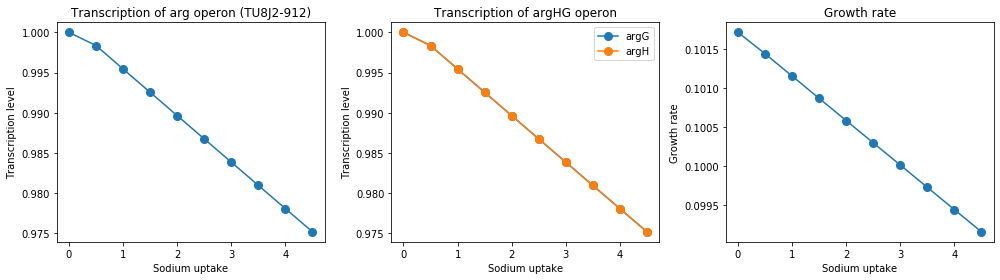

In [947]:
# Visualize transcription profiles
plt.figure(figsize=(14,4))

# TU8J2-912 operon: argCJBDF-carAB
plt.subplot(1,3,1)
expression = flux_responses_me.loc['transcription_TU8J2_912_from_BSU25200-MONOMER']/flux_responses_me.loc['biomass_dilution']
plt.plot(-flux_responses_me.loc['EX_na1_in'],
         expression/max(expression),
         marker = 'o',markersize=8)
plt.title('Transcription of arg operon (TU8J2-912)')
plt.ylabel('Transcription level')
plt.xlabel('Sodium uptake')

# argHG transcription
plt.subplot(1,3,2)
expression = flux_responses_me.loc['transcription_TU_BSU29450']/flux_responses_me.loc['biomass_dilution']
plt.plot(-flux_responses_me.loc['EX_na1_in'],
         expression/max(expression), label='argG',
         marker = 'o',markersize=8)
expression = flux_responses_me.loc['transcription_TU_BSU29440']/flux_responses_me.loc['biomass_dilution']
plt.plot(-flux_responses_me.loc['EX_na1_in'],
         expression/max(expression), label='argH',
         marker = 'o',markersize=8)
plt.legend()
plt.title('Transcription of argHG operon')
plt.ylabel('Transcription level')
plt.xlabel('Sodium uptake')

plt.subplot(1,3,3)
plt.plot(-flux_responses_me.loc['EX_na1_in'],
         flux_responses_me.loc['biomass_dilution'],
         marker = 'o',markersize=8)
plt.title('Growth rate')
plt.ylabel('Growth rate')
plt.xlabel('Sodium uptake')


plt.tight_layout()
plt.savefig('figures/salt_arginine_response.svg',format='SVG')

Text(0.5, 1.0, 'artPQR')

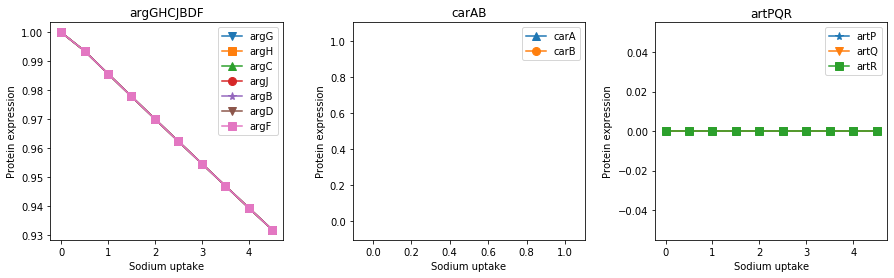

In [951]:
# Visualize protein expression profiles
plt.figure(figsize=(15,4))
import itertools
marker = itertools.cycle(('v', 's', '^', 'o', '*')) 

flux_responses_me[abs(flux_responses_me)<1e-16] = 0

plt.subplots_adjust(wspace=0.3)
plt.subplot(1,3,1)
genes = ['argG', 'argH', 'argC', 'argJ', 'argB', 'argD', 'argF']
for gene_name,locus_id in gene_dictionary.loc[genes]['locus_id'].items():
    expression = flux_responses_me.loc['translation_'+locus_id]
    expression /= np.max(expression)
    plt.plot(-flux_responses_me.loc['EX_na1_in'],expression,
            label=gene_name,marker = next(marker),markersize=8)
plt.legend()
plt.xlabel('Sodium uptake')
plt.ylabel('Protein expression')
plt.title('argGHCJBDF')

plt.subplot(1,3,2)
genes = ['carA', 'carB']
for gene_name,locus_id in gene_dictionary.loc[genes]['locus_id'].items():
    expression = flux_responses_me.loc['translation_'+locus_id]
    expression /= np.max(expression)
    plt.plot(-flux_responses_me.loc['EX_na1_in'],expression,
            label=gene_name,marker = next(marker),markersize=8)
plt.legend()
plt.xlabel('Sodium uptake')
plt.ylabel('Protein expression')
plt.title('carAB')

plt.subplot(1,3,3)
genes = ['artP', 'artQ','artR']
for gene_name,locus_id in gene_dictionary.loc[genes]['locus_id'].items():
    expression = flux_responses_me.loc['translation_'+locus_id]
    plt.plot(-flux_responses_me.loc['EX_na1_in'],expression,
            label=gene_name,marker = next(marker),markersize=8)
plt.legend()
plt.xlabel('Sodium uptake')
plt.ylabel('Protein expression')
plt.title('artPQR')

# artPQR are not included in the model

Notes:
* Sodium was forced to go through the model by creating na1_in and na1_out. Otherwise, it would have exited the model without going through the network from EX to DM

In [10]:
flux_responses_me

,-4.5,-4.0,-3.5,-3.0,-2.5,-2.0,-1.5,-1.0,-0.5,-0.0
rxn_id,,,,,,,,,,
biomass_dilution,0.099209,0.099489,0.099770,0.100049,0.100329,0.100610,0.100890,0.101171,0.101451,0.101721
protein_biomass_to_biomass,0.034911,0.035008,0.035105,0.035201,0.035298,0.035395,0.035492,0.035589,0.035686,0.035778
mRNA_biomass_to_biomass,0.000115,0.000115,0.000116,0.000116,0.000116,0.000117,0.000117,0.000118,0.000118,0.000118
tRNA_biomass_to_biomass,0.000698,0.000700,0.000702,0.000704,0.000707,0.000709,0.000711,0.000714,0.000716,0.000718
rRNA_biomass_to_biomass,0.005046,0.005063,0.005080,0.005096,0.005113,0.005130,0.005146,0.005163,0.005180,0.005196
...,...,...,...,...,...,...,...,...,...,...
BILEt4_osm,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
PIt7_osm,1.500000,1.333333,1.166667,1.000000,0.833333,0.666667,0.500000,0.333333,0.166667,0.000000
MALt4_osm,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


## Accuracy of prediction of transcription response

In [952]:
# transcription_response_dict = {}
# for r in me.reactions:
#     if 'translation' in r.id:
#         gene_id = r.id.split('_')[1]
#         transcription_rxn = get_reactions_of_met(me,'RNA_'+gene_id,only_types=['TranscriptionReaction'],verbose=False)[0]
#         for rate in flux_responses_me.columns:
#             if gene_id not in transcription_response_dict.keys():
#                 transcription_response_dict[gene_id]={}
#             if transcription_rxn.id in flux_responses_me.index:
#                 transcription_response_dict[gene_id][rate]=flux_responses_me.loc[transcription_rxn.id][rate]
# transcription_df = pd.DataFrame.from_dict(transcription_response_dict).T
# transcription_df = transcription_df[transcription_df.any(axis=1)]

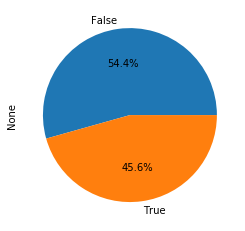

In [965]:
transcription_response = flux_responses_me.loc[flux_responses_me.index.str.contains('translation')]
all_genes = [gene.split('_')[1] for gene in transcription_response.index]
transcription_df = pd.DataFrame(data=transcription_response.values,index=all_genes,columns=transcription_response.columns)
transcription_df.any(axis=1).value_counts().plot.pie(autopct='%1.1f%%')
# Only expressed genes
transcription_df = transcription_df[transcription_df.any(axis=1)]

In [993]:
# Normalized by growth rate
# transcription_df = transcription_df.div(flux_responses_me.loc['biomass_dilution'])

What should be the threshold to identify up or downregulation in the model?

In [994]:
thresholds = np.arange(0,0.05,0.001)
accuracies = pd.DataFrame(index=thresholds,columns=['TPR','FNR','FDR','prec'])
for threshold in thresholds:

    predicted_fold_change = ((transcription_df['-4.5']-transcription_df['-0.0'])/transcription_df.max(axis=1))
    predicted_fold_change = predicted_fold_change.fillna(0)

    upregulated_genes = predicted_fold_change[predicted_fold_change>threshold]
    downregulated_genes = predicted_fold_change[predicted_fold_change<-threshold]
    rest_genes = predicted_fold_change[abs(predicted_fold_change)<=threshold]

    predicted_decision = pd.DataFrame(data=np.zeros(len(transcription_df.index)),index=transcription_df.index,columns=['reg'])
    predicted_decision.loc[upregulated_genes.index]= 1
    predicted_decision.loc[downregulated_genes.index] = -1

    decision_results = predicted_decision.join(decision_df,lsuffix='_me',rsuffix='_rna')
    
    
    # Metrics
    P = decision_results[decision_results['reg_rna'] != 0].index
    F = decision_results[decision_results['reg_rna'] == 0].index
    pP = decision_results[decision_results['reg_me'] != 0].index
    pF = decision_results[decision_results['reg_me'] == 0].index

    TP = len(decision_results[decision_results['reg_rna']==decision_results['reg_me']][decision_results['reg_rna'] != 0])
    FP = len(pP)-TP
    TN = len(decision_results[decision_results['reg_rna']==decision_results['reg_me']][decision_results['reg_rna'] == 0])
    FN = len(pF)-TN

    TPR = TP/(TP+FN)
    FNR = TN/(TN+FP)

    prec = TP/(TP+FP)
    FDR = 1-prec
    MCC = (TP*TN - FP*FN)/np.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))
    
    accuracies.loc[threshold]['TPR'] = TPR
    accuracies.loc[threshold]['FNR'] = FNR
    accuracies.loc[threshold]['FDR'] = FDR
    accuracies.loc[threshold]['prec'] = prec

    correct = sum(decision_results['reg_me'] == decision_results['reg_rna'])
    incorrect = len(decision_results.index)-correct

    accuracy = correct/len(decision_results.index)

/home/jt/UCSD/ME_modelling/ME_env/lib/python3.6/site-packages/ipykernel_launcher.py:25 UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/jt/UCSD/ME_modelling/ME_env/lib/python3.6/site-packages/ipykernel_launcher.py:27 UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Text(0, 0.5, 'Metric')

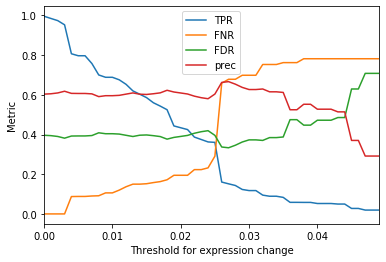

In [995]:
accuracies.plot()
plt.xlabel('Threshold for expression change')
plt.ylabel('Metric')

Seems like the model is able to capture regulation with small changes. Threshold of 0 is the best for accuracy.

In [996]:
threshold = 0.
predicted_fold_change = ((transcription_df['-4.5']-transcription_df['-0.0'])/transcription_df.max(axis=1))
predicted_fold_change = predicted_fold_change.fillna(0)

upregulated_genes = predicted_fold_change[predicted_fold_change>threshold]
downregulated_genes = predicted_fold_change[predicted_fold_change<-threshold]
rest_genes = predicted_fold_change[abs(predicted_fold_change)<=threshold]

predicted_decision = pd.DataFrame(data=np.zeros(len(transcription_df.index)),index=transcription_df.index,columns=['reg'])
predicted_decision.loc[upregulated_genes.index]= 1
predicted_decision.loc[downregulated_genes.index] = -1

decision_results = predicted_decision.join(decision_df,lsuffix='_me',rsuffix='_rna')
decision_results

correct = sum(decision_results['reg_me'] == decision_results['reg_rna'])
incorrect = len(decision_results.index)-correct

accuracy = correct/len(decision_results.index)

In [997]:
correct_df = decision_results[decision_results.reg_me==decision_results.reg_rna]
incorrect_df = decision_results[decision_results.reg_me!=decision_results.reg_rna]

In [1182]:
df = correct_df['reg_me'].value_counts().to_frame().join(incorrect_df['reg_me'].value_counts().to_frame(),rsuffix='_i')

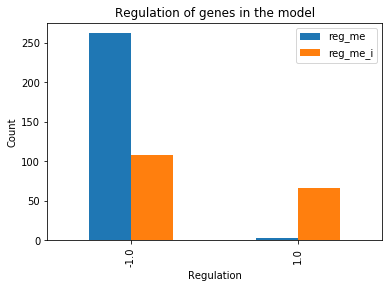

In [1183]:

df.plot.bar()
plt.xlabel('Regulation')
plt.ylabel('Count')
plt.title('Regulation of genes in the model')
plt.savefig('figures/salt_regulated_genes.svg',format='SVG')

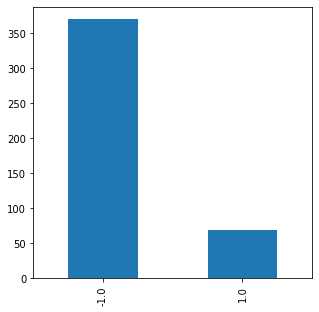

In [1198]:
df.sum(axis=1).plot.bar(figsize = (5,5))
plt.savefig('figures/abs_salt_regulated_genes.svg',format='SVG')

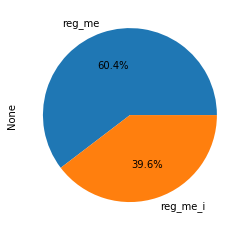

In [1193]:
df.sum().plot.pie(autopct='%1.1f%%')
plt.savefig('figures/diffregulated_genes_pie.svg',format='SVG')

In [1001]:
df.div(df.sum(axis=1),axis=0)

,reg_me,reg_me_i
-1.0,0.708108,0.291892
1.0,0.043478,0.956522


In [1002]:
decision_results[decision_results['reg_me']<0].to_csv('reg_me.csv')

In [1003]:
decision_results[decision_results['reg_rna']<0].to_csv('reg_rna.csv')

In [1004]:
annotation_df = pd.read_csv('gene_annotation.csv',index_col=0)

In [1005]:
annotation_df

,annotation
BSU00090,S_Nucleotides_and_nucleic_acids
BSU00110,S_Coenzymes_and_prosthetic_groups
BSU00120,S_Coenzymes_and_prosthetic_groups
BSU00130,charging
BSU00140,S_Nucleotides_and_nucleic_acids
...,...
BSU40890,formation
BSU40910,formation
BSU41050,formation
BSU41060,formation


In [1013]:
df = decision_results
upreg_genes = df.loc[df['reg_me']==1].index
downreg_genes = df.loc[df['reg_me']==-1].index
noreg_genes = df.loc[df['reg_me']==0].index

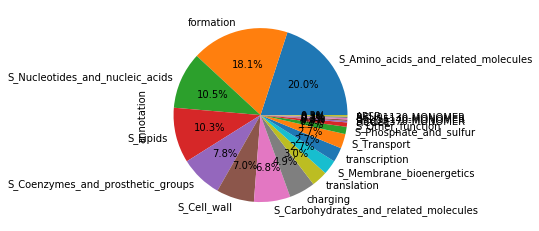

In [1203]:
annotation_df.loc[downreg_genes]['annotation'].value_counts().plot.pie(autopct='%1.1f%%')
plt.savefig('figures/salt_downregulated_genes.svg',format='SVG')

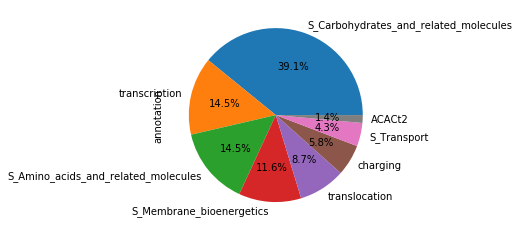

In [1204]:
annotation_df.loc[upreg_genes]['annotation'].value_counts().plot.pie(autopct='%1.1f%%')
plt.savefig('figures/salt_upregulated_genes.svg',format='SVG')

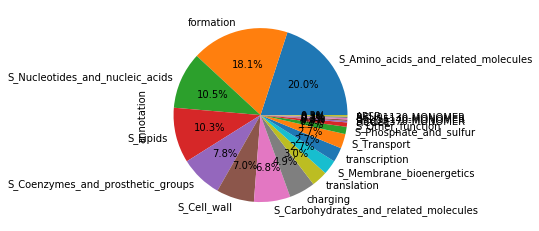

In [1014]:
annotation_df.loc[df.loc[df['reg_me']==-1].index]['annotation'].value_counts().plot.pie(autopct='%1.1f%%')
plt.savefig('figures/correct_downregulated_genes.svg',format='SVG')

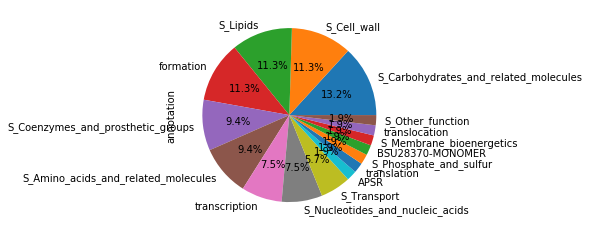

In [1016]:
annotation_df.loc[df.loc[df['reg_rna']==1].index]['annotation'].value_counts().plot.pie(autopct='%1.1f%%')
plt.savefig('figures/correct_upregulated_genes.svg',format='SVG')

In [982]:
df = incorrect_df
upreg_genes = df.loc[df['reg_me']==1].index
downreg_genes = df.loc[df['reg_me']==-1].index
noreg_genes = df.loc[df['reg_me']==0].index

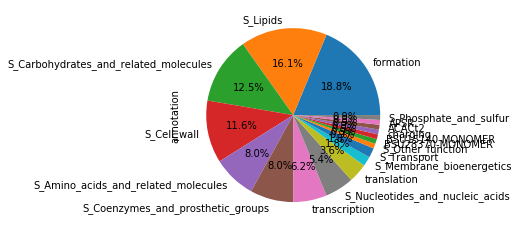

In [983]:
annotation_df.loc[downreg_genes]['annotation'].value_counts().plot.pie(autopct='%1.1f%%')
plt.savefig('figures/incorrect_downregulated_genes.svg',format='SVG')

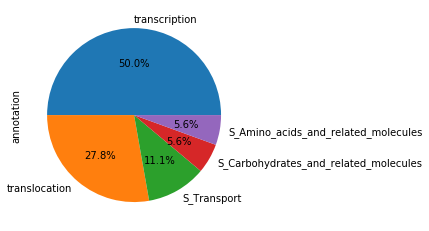

In [984]:
annotation_df.loc[upreg_genes]['annotation'].value_counts().plot.pie(autopct='%1.1f%%')
plt.savefig('figures/incorrect_upregulated_genes.svg',format='SVG')

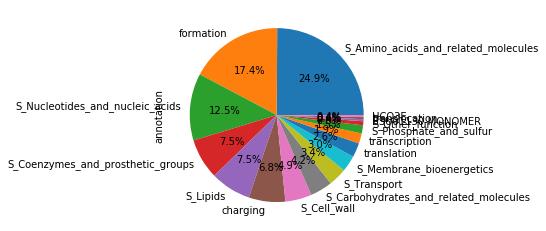

In [1190]:
annotation_df.loc[correct_df.index]['annotation'].value_counts().plot.pie(autopct='%1.1f%%')
plt.savefig('figures/correct_diffregulated_genes.svg',format='SVG')

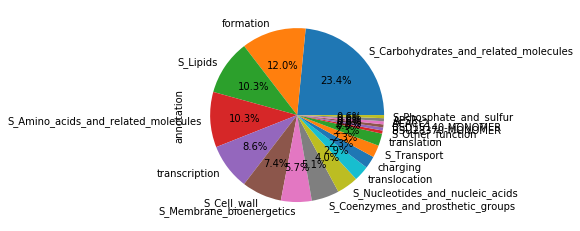

In [1191]:
annotation_df.loc[incorrect_df.index]['annotation'].value_counts().plot.pie(autopct='%1.1f%%')
plt.savefig('figures/incorrect_diffregulated_genes.svg',format='SVG')

In [1138]:
#flux_responses_me = flux_responses_me.div(flux_responses_me.loc['biomass_dilution'])

In [1164]:
df = flux_responses_me.loc[[r.id for r in get_reactions_of_met(me,'arg__L_c',verbose=False)]].sort_values(by='-4.5',ascending=False)
df

/home/jt/UCSD/ME_modelling/ME_env/lib/python3.6/site-packages/ipykernel_launcher.py:1 FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike


,-4.5,-4.0,-3.5,-3.0,-2.5,-2.0,-1.5,-1.0,-0.5,-0.0
rxn_id,,,,,,,,,,
ARGSL_FWD_BSU29440-MONOMER,2.545980e-02,0.025563,2.566630e-02,0.025770,2.587329e-02,2.597716e-02,0.026081,0.026185,0.026290,2.635892e-02
charging_tRNA_BSU_tRNA_26_CGU,8.317247e-03,0.008348,8.379658e-03,0.008411,8.442168e-03,8.473526e-03,0.008505,0.000000,0.008568,8.591580e-03
charging_tRNA_BSU_tRNA_26_CGC,8.158822e-03,0.008188,8.217654e-03,0.008247,8.276563e-03,8.306106e-03,0.008336,0.000000,0.008395,8.418052e-03
charging_tRNA_BSU_tRNA_26_AGA,5.078759e-03,0.000000,0.000000e+00,0.005168,5.197733e-03,5.227701e-03,0.005258,0.000000,0.000000,0.000000e+00
charging_tRNA_BSU_tRNA_26_CGG,2.558753e-03,0.002571,2.582963e-03,0.000000,0.000000e+00,2.619465e-03,0.002632,0.000000,0.002656,2.662139e-03
...,...,...,...,...,...,...,...,...,...,...
translation_BSU19230,-2.438146e-24,0.000000,-2.465787e-24,0.000000,-2.493535e-24,-2.507492e-24,0.000000,0.000000,0.000000,-2.563178e-24
translation_BSU04620,-3.587791e-24,0.000000,-3.628464e-24,0.000000,-3.669297e-24,-3.689834e-24,0.000000,0.000000,0.000000,-3.771778e-24
translation_BSU28900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [1165]:
a = df['-4.5']-df['-0.0']
a[a.abs().sort_values(ascending=False).index].head(10)

rxn_id
charging_tRNA_BSU_tRNA_79_AGA   -0.005332
charging_tRNA_BSU_tRNA_26_AGA    0.005079
ARGSL_FWD_BSU29440-MONOMER      -0.000899
charging_tRNA_BSU_tRNA_79_AGG   -0.000603
charging_tRNA_BSU_tRNA_26_AGG    0.000598
charging_tRNA_BSU_tRNA_26_CGU   -0.000274
charging_tRNA_BSU_tRNA_26_CGC   -0.000259
charging_tRNA_BSU_tRNA_26_CGG   -0.000103
translation_BSU22890            -0.000041
translation_dummy               -0.000015
dtype: float64

In [1169]:
me.reactions.get_by_id('charging_tRNA_BSU_tRNA_79_AGA').reaction

'4.27350427350427e-6*mu*(0.000116266666666667*mu + 1.0000455184) BSU37330-MONOMER + 0.000116266666666667*mu + 4.55184e-5 RNA_BSU_tRNA_79 + 0.000116266666666667*mu + 4.55184e-5 arg__L_c --> generic_tRNA_AGA_arg__L_c'

In [1174]:
me.reactions.get_by_id('charging_tRNA_BSU_tRNA_79_AGG').reaction

'4.27350427350427e-6*mu*(0.000116266666666667*mu + 1.0000455184) BSU37330-MONOMER + 0.000116266666666667*mu + 4.55184e-5 RNA_BSU_tRNA_79 + 0.000116266666666667*mu + 4.55184e-5 arg__L_c --> generic_tRNA_AGG_arg__L_c'

In [1172]:
df = flux_responses_me.loc[[r.id for r in get_reactions_of_met(me,'generic_tRNA_AGG_arg__L_c',verbose=False)]].sort_values(by='-4.5',ascending=False)
a = df['-4.5']-df['-0.0']
a[a.abs().sort_values(ascending=False).index].head(10)

rxn_id
charging_tRNA_BSU_tRNA_79_AGG   -6.028649e-04
charging_tRNA_BSU_tRNA_26_AGG    5.984680e-04
translation_BSU22550            -5.037034e-07
translation_BSU22540            -5.037034e-07
translation_BSU36880            -3.757413e-07
translation_BSU36820            -3.757413e-07
translation_BSU31630             3.179770e-07
translation_BSU31620             3.179770e-07
translation_BSU14890            -2.991210e-07
translation_BSU14900            -2.991210e-07
dtype: float64

In [1179]:
df = flux_responses_me.loc[[r.id for r in get_reactions_of_met(me,'CPLX8J2-42',verbose=False)]].sort_values(by='-4.5',ascending=False)
a = df['-4.5']-df['-0.0']
a[a.abs().sort_values(ascending=False).index].head(10)

rxn_id
CYOR3m_FWD_CPLX8J2-42    2.047745e-01
formation_CPLX8J2-42    -5.037034e-07
dtype: float64

In [1175]:
for r in get_final_reactions_of_gene(me,'BSU22550'):
    print(r.id, flux_responses_me.loc[r.id],'\n')

CYOR3m_FWD_CPLX8J2-42 -4.5    11.766504
-4.0    11.743801
-3.5    11.721097
-3.0    11.698325
-2.5    11.675619
-2.0    11.652912
-1.5    11.630203
-1.0    11.607494
-0.5    11.584784
-0.0    11.561730
Name: CYOR3m_FWD_CPLX8J2-42, dtype: float64 



In [1176]:
me.reactions.get_by_id('CYOR3m_FWD_CPLX8J2-42').reaction

'5.7732452227792e-5*mu CPLX8J2-42 + 2.0 ficytcc_c + h_c + mql7_c <=> 2.0 focytcc_c + 3.0 h_e + mqn7_c'

In [1155]:
me.reactions.get_by_id('CYTK2_FWD_BSU22890-MONOMER_mod_mg2').upper_bound=0
solve_me_model(me, max_mu = 0.5, min_mu = .05, using_soplex=False, precision = 1e-6)

iter	muopt    	a     	b     	mu1       	stat1
Finished compiling expressions in 209.174154 seconds
Finished substituting S,lb,ub in 9.437297 seconds
Finished makeME_LP in 1.099185 seconds
Getting MINOS parameters from ME_NLP...
1 0.0 0.0 0.25 0.25 1
Finished substituting S,lb,ub in 9.482603 seconds
Finished makeME_LP in 1.070385 seconds
Getting MINOS parameters from ME_NLP...
2 0.0 0.0 0.125 0.125 1
Finished substituting S,lb,ub in 9.545015 seconds
Finished makeME_LP in 1.074657 seconds
Getting MINOS parameters from ME_NLP...
3 0.0625 0.0625 0.125 0.0625 optimal
Finished substituting S,lb,ub in 9.225311 seconds
Finished makeME_LP in 1.090679 seconds
Getting MINOS parameters from ME_NLP...
4 0.09375 0.09375 0.125 0.09375 optimal
Finished substituting S,lb,ub in 9.124359 seconds
Finished makeME_LP in 1.075693 seconds
Getting MINOS parameters from ME_NLP...
5 0.09375 0.09375 0.109375 0.109375 1
Finished substituting S,lb,ub in 8.884513 seconds
Finished makeME_LP in 1.072270 seconds
Gettin

In [1162]:
df = flux_responses_me.loc[[r.id for r in get_reactions_of_met(me,'mg2_c',verbose=False)]].sort_values(by='-4.5',ascending=False)
a = df['-4.5']-df['-0.0']
a[a.abs().sort_values(ascending=False).index].head(20)

rxn_id
MGt5_REV_BSU08000-MONOMER                              -2.656547e-04
formation_BSU22890-MONOMER_mod_mg2                     -2.405282e-04
formation_ribosome                                     -1.457887e-07
formation_BSU01370-MONOMER_mod_mg2                     -6.643610e-08
formation_BSU00500-MONOMER_mod_mg2                     -3.118759e-08
formation_BSU13120-MONOMER_mod_mg2                     -2.439062e-08
formation_BSU15200-MONOMER_mod_mg2_mod_k               -1.957701e-08
formation_BSU28290-MONOMER_mod_mg2                     -1.301529e-08
formation_BSU03150-MONOMER_mod_mg2                     -1.142416e-08
formation_BSU11210-MONOMER_mod_mg2                     -8.802460e-09
formation_BSU06530-MONOMER_mod_mg2                     -4.015354e-09
formation_BSU29450-MONOMER_mod_mg2                     -3.842396e-09
formation_BSU16540-MONOMER_mod_mg2_mod_k               -2.975154e-09
formation_BSU00280-MONOMER_mod_mg2                     -2.713110e-09
formation_BSU02230-MONOMER_

In [1149]:
get_reactions_of_met(me,'BSU22890-MONOMER_mod_mg2')

( CYTK1_FWD_BSU22890-MONOMER_mod_mg2 0 999999.0 ) 	 4.27350427350427e-6*mu BSU22890-MONOMER_mod_mg2 + atp_c + cmp_c <=> adp_c + cdp_c
( URIDK2r_copy1_FWD_BSU22890-MONOMER_mod_mg2 0 999999.0 ) 	 4.27350427350427e-6*mu BSU22890-MONOMER_mod_mg2 + atp_c + dump_c <=> adp_c + dudp_c
( CYTK2_REV_BSU22890-MONOMER_mod_mg2 0 999999.0 ) 	 1.77501774789151e-5*mu BSU22890-MONOMER_mod_mg2 + adp_c + dcdp_c <=> atp_c + dcmp_c
( CYTK2_FWD_BSU22890-MONOMER_mod_mg2 0 999999.0 ) 	 1.77501774789151e-5*mu BSU22890-MONOMER_mod_mg2 + atp_c + dcmp_c <=> adp_c + dcdp_c
( UMPK_FWD_BSU22890-MONOMER_mod_mg2 0 999999.0 ) 	 4.27350427350427e-6*mu BSU22890-MONOMER_mod_mg2 + atp_c + ump_c <=> adp_c + udp_c
( formation_BSU22890-MONOMER_mod_mg2 0.0 1000.0 ) 	 mg2_c + protein_BSU22890 --> BSU22890-MONOMER_mod_mg2 + 0.04861 prosthetic_group_biomass
( CYTK1_REV_BSU22890-MONOMER_mod_mg2 0 999999.0 ) 	 4.27350427350427e-6*mu BSU22890-MONOMER_mod_mg2 + adp_c + cdp_c <=> atp_c + cmp_c


[<MetabolicReaction CYTK1_FWD_BSU22890-MONOMER_mod_mg2 at 0x7f87031f8400>,
 <MetabolicReaction URIDK2r_copy1_FWD_BSU22890-MONOMER_mod_mg2 at 0x7f87033dc518>,
 <MetabolicReaction CYTK2_REV_BSU22890-MONOMER_mod_mg2 at 0x7f87031f8358>,
 <MetabolicReaction CYTK2_FWD_BSU22890-MONOMER_mod_mg2 at 0x7f87031f8588>,
 <MetabolicReaction UMPK_FWD_BSU22890-MONOMER_mod_mg2 at 0x7f87033dc898>,
 <ComplexFormation formation_BSU22890-MONOMER_mod_mg2 at 0x7f86e9122ba8>,
 <MetabolicReaction CYTK1_REV_BSU22890-MONOMER_mod_mg2 at 0x7f87031f8198>]

In [1161]:
for r in get_transport_reactions(me,'mg2_c'):
    print(r.reaction)

4.27350427350427e-6*mu BSU07610-MONOMER + h_e + icit_e + mg2_e <=> h_c + icit_c + mg2_c
4.27350427350427e-6*mu BSU08000-MONOMER + mg2_e <=> mg2_c
4.27350427350427e-6*mu BSU07610-MONOMER + cit_e + h_e + mg2_e <=> cit_c + h_c + mg2_c
9.41391740137433e-5*mu BSU24740-MONOMER + mg2_e <=> mg2_c
4.27350427350427e-6*mu BSU13300-MONOMER + mg2_e <=> mg2_c


In [1124]:
me.reactions.get_by_id('CYTK2_REV_BSU22890-MONOMER_mod_mg2').reaction

'1.77501774789151e-5*mu BSU22890-MONOMER_mod_mg2 + adp_c + dcdp_c <=> atp_c + dcmp_c'

In [1118]:
me.reactions.get_by_id('CYTK2_FWD_BSU22890-MONOMER_mod_mg2').reaction

'1.77501774789151e-5*mu BSU22890-MONOMER_mod_mg2 + atp_c + dcmp_c <=> adp_c + dcdp_c'

In [1091]:
me.metabolites.get_by_id('cdpglyc_c').name

'CDPglycerol C12H19N3O13P2'

In [1093]:
df = flux_responses_me.loc[[r.id for r in get_reactions_of_met(me,'cdpglyc_c',verbose=False)]].sort_values(by='-4.5',ascending=False)
a = df['-4.5']-df['-0.0']
a[a.abs().sort_values(ascending=False).index].head(10)

/home/jt/UCSD/ME_modelling/ME_env/lib/python3.6/site-packages/ipykernel_launcher.py:1 FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike


rxn_id
G3PCT_FWD_BSU35740-MONOMER   -1.157896e-03
LIPO3S24_BS_FWD_CPLX000-53   -4.521561e-08
LIPO4S24_BS_FWD_CPLX_dummy   -3.767967e-08
LIPO1S24_BS_FWD_CPLX_dummy   -1.758385e-08
LIPO2S24_BS_FWD_CPLX_dummy   -1.507187e-08
G3PCT_FWD_CPLX-5322           0.000000e+00
TECA1S45_FWD_CPLX000-65                NaN
TECA3S45_FWD_CPLX000-67                NaN
TECA2S45_FWD_CPLX000-66                NaN
dtype: float64

In [1095]:
me.reactions.get_by_id('LIPO3S24_BS_FWD_CPLX000-53').reaction

'4.27350427350427e-6*mu CPLX000-53 + 2400.0 ala__D_c + 2400.0 atp_c + 2400.0 cdpglyc_c + d12dg_BS_c + 2400.0 h2o_c <=> 2400.0 amp_c + 2400.0 cmp_c + 4800.0 h_c + lipo3_24_BS_c + 2400.0 ppi_c'

In [1099]:
df = flux_responses_me.loc[[r.id for r in get_reactions_of_met(me,'lipid_biomass',verbose=False)]].sort_values(by='-4.5',ascending=False)
a = df['-4.5']-df['-0.0']
a[a.abs().sort_values(ascending=False).index].head(10)

rxn_id
Demand_lipo2_24_BS_c    -0.002512
Demand_pgly_BS_c        -0.002512
Demand_tcam_BS_c        -0.002512
Demand_gtca2_45_BS_c    -0.002512
Demand_lysylpgly_BS_c   -0.002512
Demand_lipo3_24_BS_c    -0.002512
Demand_cdlp_BS_c        -0.002512
Demand_d12dg_BS_c       -0.002512
Demand_lipo1_24_BS_c    -0.002512
Demand_m12dg_BS_c       -0.002512
dtype: float64

In [1097]:
flux_responses_me.loc['lipid_dilution']

KeyError: 'lipid_dilution'